In [250]:
import polars as pl
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter

#from matplotlib.dates import DateFormatter


In [251]:

# Read the combined CSV file
combined_df = pl.read_csv("all_chains_daily_results.csv")

# Group the DataFrame by the 'chain' column and create a dictionary
daily_results_dict = {
    chain: group_df.drop("chain")
    for chain, group_df in combined_df.groupby("chain")
}

for chain, df in daily_results_dict.items():
    daily_results_dict[chain] = df.with_columns(
        pl.col('date').str.strptime(pl.Date, '%Y-%m-%d').alias('date')
    )

# Display the keys of the resulting dictionary
print(daily_results_dict.keys())

dict_keys(['arbitrum2', 'zksync', 'base', 'arbitrum', 'ethereum', 'optimism'])


/var/folders/y_/27jchs_x56gfpv07wkchjxj40000gn/T/ipykernel_22656/3048667376.py:7: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  for chain, group_df in combined_df.groupby("chain")
/var/folders/y_/27jchs_x56gfpv07wkchjxj40000gn/T/ipykernel_22656/3048667376.py:5: DeprecationWarning: `group_by` iteration will change to always return group identifiers as tuples. Pass `by` as a list to silence this warning, e.g. `group_by(['chain'])`.
  daily_results_dict = {


In [252]:
# Constants

MULTI = 1e12
LP_FEE = 0.0005    # 20bps at ZKsync
DAYS = 365
alpha = 2_400
ZKSYNC = 8
ETHEREUM = 0.25
R_S = 0.0347
r_W = 100_000_000
W = r_W / alpha

W = 0
ETHEREUM = 1

# Iterate over each chain in the dictionary and perform operations
for chain, df in daily_results_dict.items():
    print(chain)
    
    # Step 6: Calculate optimal allocation
    df = df.with_columns([
        (pl.col('real_TVL') * ((pl.col('r_annual_return') / R_S).pow(0.5) - 1)).alias('allocation')
    ])
    
    # Step 7: Calculate new_return and ensure it is correctly added
    df = df.with_columns([
        ((pl.col('daily_volume_USD') / alpha) * LP_FEE / (pl.col('real_TVL') + pl.col('allocation'))).alias('new_return')
    ])
    

    #becaucse LP fee at zksync is 20bps, not 5bps
    if (chain == 'zksync'):
        df = df.with_columns(
            (ZKSYNC * pl.col('new_return')).alias('new_return')
        )

    if (chain == 'ethereum'):
        df = df.with_columns(
            (ETHEREUM * pl.col('new_return')).alias('new_return')
        )

    df = df.with_columns(
        new_return_ap = (1 + pl.col('new_return')).pow(DAYS) - 1
    )

    # Update the DataFrame in the dictionary
    daily_results_dict[chain] = df

# Print confirmation of processing
print("Processing completed for all chains.")



arbitrum2
zksync
base
arbitrum
ethereum
optimism
Processing completed for all chains.


In [253]:

daily_results_dict['arbitrum']


date,daily_volume_USD,virtual_TVL,real_TVL,v_daily_return,r_daily_return,v_annual_return,r_annual_return,allocation,new_return,new_return_ap
date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-04-10,1.2642e8,4.8142e8,120318.748936,0.000131,0.000219,0.049086,0.083164,65947.860722,0.000141,0.052959
2024-04-04,7.9979e7,3.3531e8,83812.623866,0.000119,0.000199,0.044489,0.075253,39613.760248,0.000135,0.050505
2024-04-07,4.8868e7,3.1599e8,78982.849784,0.000077,0.000129,0.028625,0.048169,14075.084318,0.000109,0.040738
2024-04-28,7.7677e7,5.5771e8,139397.134415,0.00007,0.000116,0.025743,0.043281,16284.779938,0.000104,0.038668
2024-04-01,9.0959e7,3.6026e8,90035.771668,0.000126,0.00021,0.047153,0.079841,46536.451087,0.000139,0.051946
…,…,…,…,…,…,…,…,…,…,…
2024-04-21,8.3556e7,6.3069e8,157644.571867,0.000066,0.00011,0.024472,0.041125,13975.851471,0.000101,0.037714
2024-04-30,1.4513e8,3.5025e8,87534.743785,0.000207,0.000345,0.078544,0.134341,84699.597701,0.000176,0.066166
2024-03-05,2.0118e8,3.5939e8,89830.637335,0.00028,0.000467,0.107544,0.185609,117928.090815,0.000202,0.076403


In [254]:
from plot_utils_2 import get_plotly_layout
from plot_utils_2 import colors
width, height = 1000, 450

plot_settings = {
    'ethereum': {'color': colors['blue'],   'label': 'Ethereum', 'style': 'solid', 'width': 1.5, 'marker_symbol': 'circle'},
    'arbitrum': {'color': colors['green'],  'label': 'Arbitrum', 'style': 'dotted', 'width': 2, 'marker_symbol': 'square'},
    'arbitrum2': {'color': colors['brown'],    'label': 'Arbitrum(e)', 'style': 'dashed', 'width': 1.5, 'marker_symbol': 'star'},
    'base': {'color': colors['red'],        'label': 'Base', 'style': 'dashed', 'width': 1.5, 'marker_symbol': 'diamond'},
    'optimism': {'color': colors['grey'],   'label': 'Optimism', 'style': 'dashdot', 'width': 2, 'marker_symbol': 'triangle-up'},
    'zksync': {'color': colors['pink'],     'label': 'ZKsync', 'style': 'solid', 'width': 1, 'marker_symbol': 'cross'},
}

chains = [
    'ethereum',
    'arbitrum',
    'arbitrum2',
    'base',
    'optimism',
    'zksync'
]



In [255]:
min_date = min(df['date'].min() for df in daily_results_dict.values())
max_date = max(df['date'].max() for df in daily_results_dict.values())

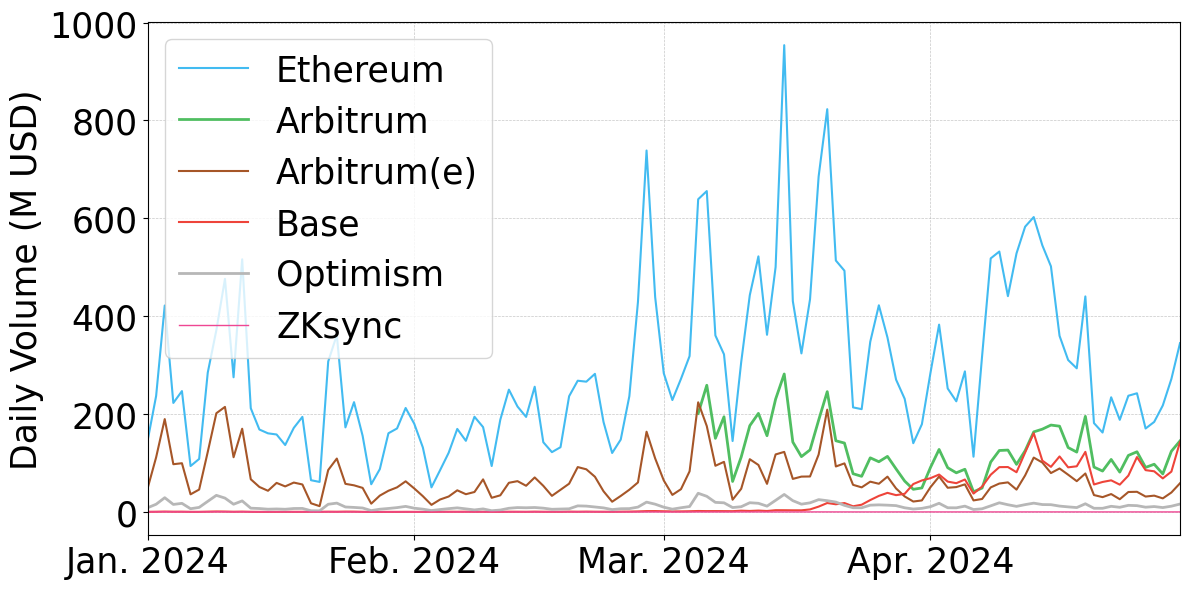

In [256]:
# --- Line Plot: Dates vs. Daily Volume by Chain (Sorted) ---
plt.figure(figsize=(12, 6))

for chain in chains:
    df = daily_results_dict[chain]
    # Sort the DataFrame by date
    df = df.sort('date')
    if chain.lower() in plot_settings:
        settings = plot_settings[chain.lower()]
        
        # Sort by date and plot
        df = df.sort('date')
        plt.plot(
            df['date'], df['daily_volume_USD'] / 1e6,
            color=settings['color'],
            linestyle='-',#settings['style'],#'-',  # Use a solid line for better readability in print
            linewidth=settings['width'],#1.5,  # Slightly thinner lines for a clean look
            label=settings['label']
        )


# Customize the plot
#plt.title('Daily Trading Volume in WETH-USDC Pools Across Different Chains')
#plt.xlabel('Date')
plt.ylabel('Daily Volume (M USD)', fontsize=25)

plt.gca().xaxis.set_major_formatter(DateFormatter('%b. %Y'))  # Format x-axis as "Month. Year"
plt.gca().xaxis.set_major_locator(MonthLocator(interval=1))  # 1-month intervals

# Customize the plot
plt.xticks(rotation=0, fontsize=25)  # Rotate x-axis labels for readability
plt.yticks(fontsize=25)
#plt.legend(fontsize=10, frameon=False)  # Simplified legend
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)  # Light grid for better visibility
plt.legend(fontsize=25)
#plt.legend()

plt.xlim(min_date,max_date)

# Tight layout for better spacing
plt.tight_layout()
# Save the figure for academic use
plt.savefig('./LP_plots/volume_by_chain.png', dpi=300, bbox_inches='tight')  # High-resolution output

plt.grid(True)
plt.show()


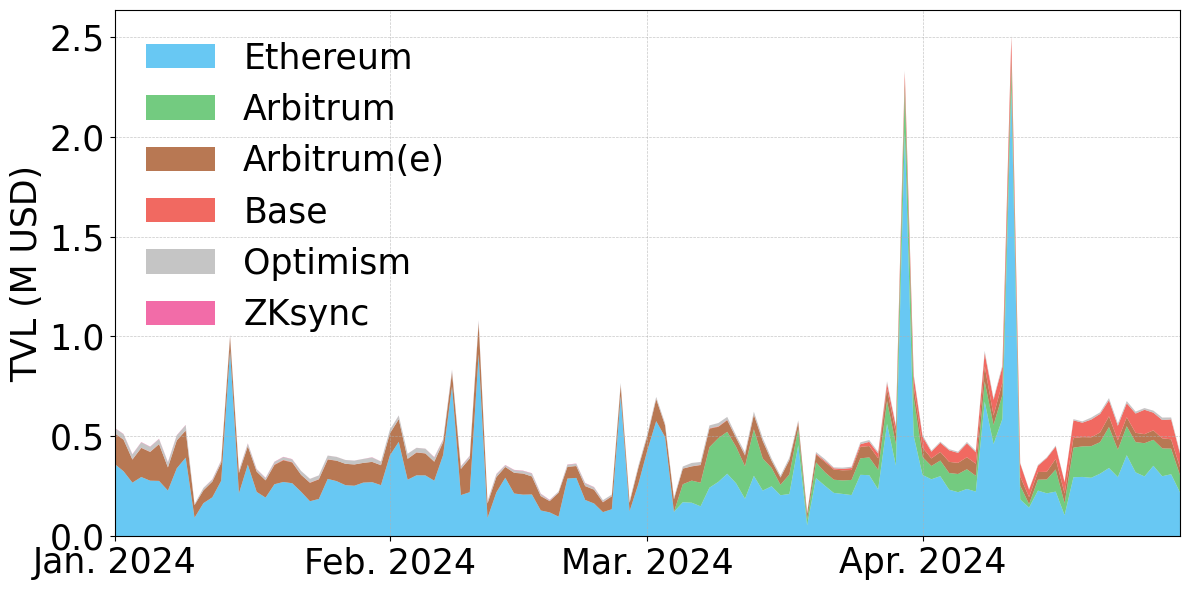

In [257]:
import pandas as pd  # For aligning and processing data

# Ensure all chains have the same date range
all_dates = pd.date_range(
    start=min(df['date'].min() for df in daily_results_dict.values()),
    end=max(df['date'].max() for df in daily_results_dict.values()),
    freq='D'
)

# Prepare aligned data
aligned_data = []
labels = []
colors = []

for chain in chains:
    df = daily_results_dict[chain]
    if chain.lower() in plot_settings:
        settings = plot_settings[chain.lower()]

        # Align data by reindexing to the full date range
        df = pd.DataFrame({'date': df['date'], 'real_TVL': df['real_TVL']}).set_index('date')
        df = df.reindex(all_dates, fill_value=0)  # Fill missing dates with 0

        # Collect TVL data and chain metadata
        aligned_data.append(df['real_TVL'].values / 1e6)
        labels.append(settings['label'])
        colors.append(settings['color'])

# Plot the stacked area chart
plt.figure(figsize=(12, 6))
plt.stackplot(all_dates, aligned_data, labels=labels, colors=colors, alpha=0.8)

# Customize the plot
#plt.title('TVL (Current Tick) in WETH-USDC Pools Across Different Chains')
#plt.xlabel('Date')
plt.ylabel('TVL (M USD)', fontsize=25)

# Format the x-axis to display dates cleanly
plt.gca().xaxis.set_major_formatter(DateFormatter('%b. %Y'))  # Format x-axis as "Month. Year"
plt.gca().xaxis.set_major_locator(MonthLocator(interval=1))  # 1-month intervals
plt.xticks(rotation=0, fontsize=25)  # Rotate x-axis labels for readability
plt.yticks(fontsize=25)

plt.xlim(min_date,max_date)

# Add legend and grid
plt.legend(loc='upper left', fontsize=25, frameon=False)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Tight layout for better spacing
plt.tight_layout()

# Save the figure for academic use
plt.savefig('./LP_plots/tvl_by_chain.png', dpi=300, bbox_inches='tight')  # High-resolution output

# Show the plot
plt.show()


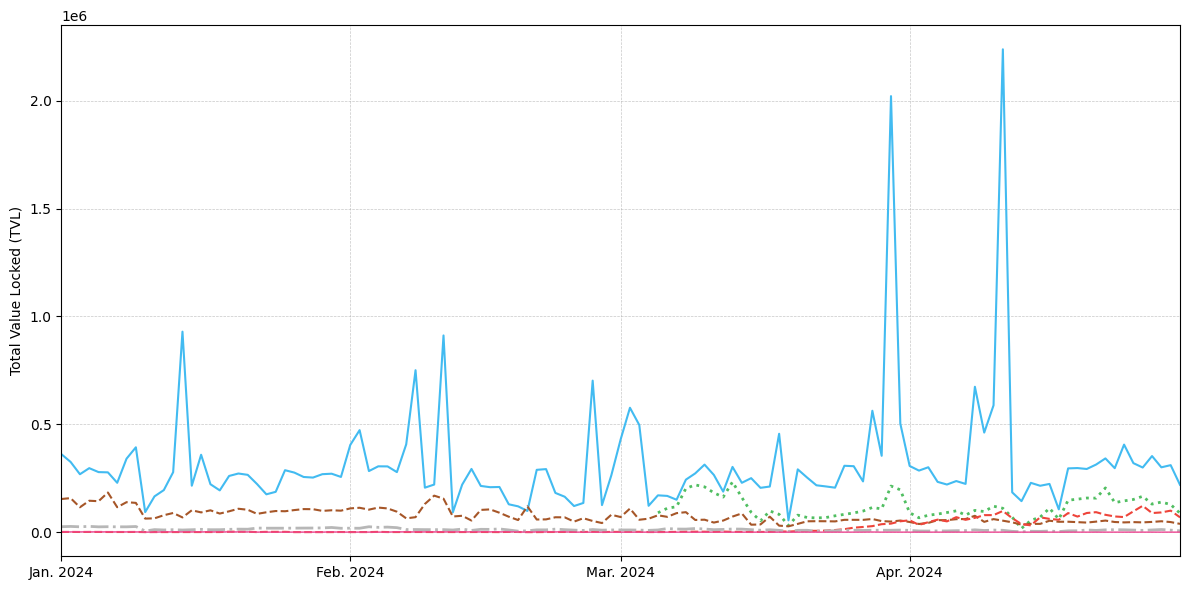

In [258]:
# --- Line Plot: Daily TVL by Chain ---
plt.figure(figsize=(12, 6))  # Adjust figure size for academic formatting
for chain in chains:
    df = daily_results_dict[chain]

    if chain.lower() in plot_settings:
        settings = plot_settings[chain.lower()]
        
        # Sort by date and plot
        df = df.sort('date')
        plt.plot(
            df['date'], df['real_TVL'],
            color=settings['color'],
            linestyle=settings['style'],#'-',  # Use a solid line for better readability in print
            linewidth=settings['width'],#1.5,  # Slightly thinner lines for a clean look
            label=settings['label']
        )

# Customize the plot
#plt.title('TVL (Current Tick) in WETH-USDC Pools Across Different Chains')  # Academic-style title
#plt.xlabel('Date')
plt.ylabel('Total Value Locked (TVL)')

plt.gca().xaxis.set_major_formatter(DateFormatter('%b. %Y'))  # Format x-axis as "Month. Year"
plt.gca().xaxis.set_major_locator(MonthLocator(interval=1))  # 1-month intervals

# Customize the plot
plt.xticks(rotation=0, fontsize=10)  # Rotate x-axis labels for readability
plt.yticks(fontsize=10)
#plt.legend(fontsize=10, frameon=False)  # Simplified legend
#plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)  # Light grid for better visibility
plt.xlim(min_date,max_date)

# Tight layout for better spacing
plt.tight_layout()

# Save the figure for academic use
plt.savefig('./LP_plots/tvl_by_chain2.png', dpi=300, bbox_inches='tight')  # High-resolution output

# Show the plot
plt.show()


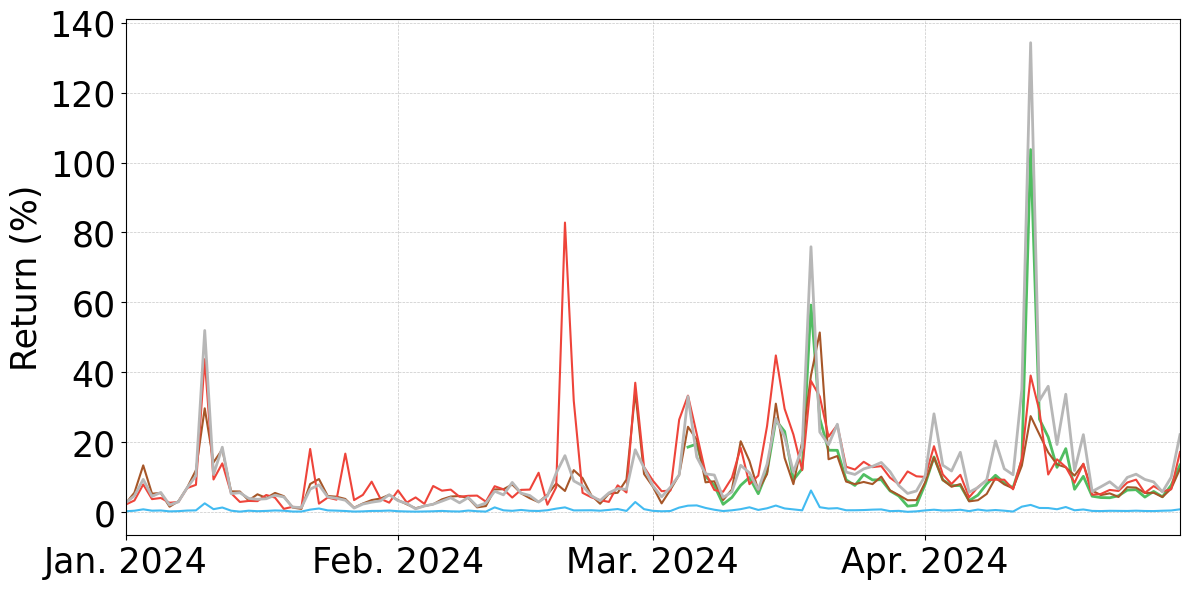

In [259]:
# --- Line Plot: Daily TVL by Chain ---
plt.figure(figsize=(12, 6))  # Adjust figure size for academic formatting
for chain in chains:
    df = daily_results_dict[chain]
    if (chain.lower() != 'zksync'):
        if chain.lower() in plot_settings:
            settings = plot_settings[chain.lower()]
            
            # Sort by date and plot
            df = df.sort('date')
            plt.plot(
                df['date'], df['r_annual_return'] * 100,
                color=settings['color'],
                linestyle='-',#settings['style'],  # Use a solid line for better readability in print
                linewidth=settings['width'],#1.5,  # Slightly thinner lines for a clean look
                label=settings['label']
            )

# Customize the plot
#plt.title('Annualized Daily LP Return in WETH-USDC Pools Across Different Chains')  # Academic-style title
#plt.xlabel('Date')
plt.ylabel('Return (%)', fontsize=25)

plt.gca().xaxis.set_major_formatter(DateFormatter('%b. %Y'))  # Format x-axis as "Month. Year"
plt.gca().xaxis.set_major_locator(MonthLocator(interval=1))  # 1-month intervals

# Customize the plot
plt.xticks(rotation=0, fontsize=25)  # Rotate x-axis labels for readability
plt.yticks(fontsize=25)
#plt.legend(fontsize=10, frameon=False)  # Simplified legend
#plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)  # Light grid for better visibility
plt.xlim(min_date,max_date)

# Tight layout for better spacing
plt.tight_layout()

# Save the figure for academic use
plt.savefig('./LP_plots/LP_return_by_chain.png', dpi=300, bbox_inches='tight')  # High-resolution output

# Show the plot
plt.show()


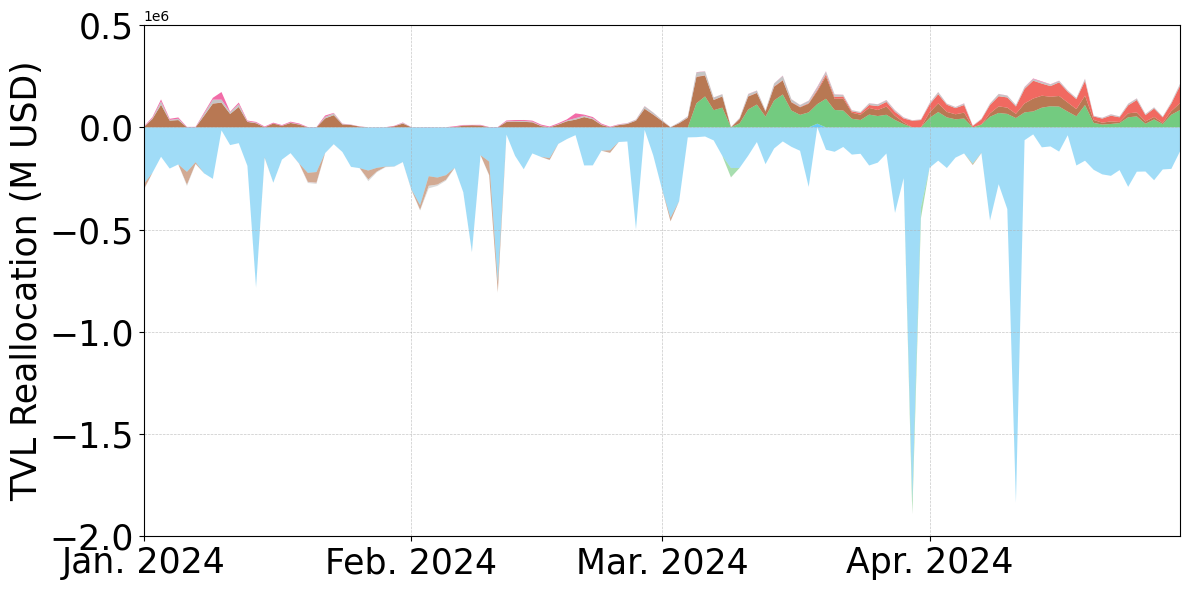

In [260]:
import pandas as pd  # For alignment of dates if needed

# --- Stacked Area Plot: Allocation by Chain (Positive and Negative) ---
plt.figure(figsize=(12, 6))  # Adjust figure size for academic formatting

# Align all data to a common date range
all_dates = pd.date_range(
    start=min(df['date'].min() for df in daily_results_dict.values()),
    end=max(df['date'].max() for df in daily_results_dict.values()),
    freq='D'
)

# Prepare aligned data for stacking
positive_data = []
negative_data = []
labels = []
colors = []

for chain in chains:
    df = daily_results_dict[chain]
    if chain.lower() in plot_settings:
        settings = plot_settings[chain.lower()]
        
        # Align data to the full date range
        df = pd.DataFrame({'date': df['date'], 'allocation': df['allocation']}).set_index('date')
        df = df.reindex(all_dates, fill_value=0)  # Fill missing dates with 0
        
        # Separate positive and negative values
        positive_data.append(df['allocation'].clip(lower=0).values)  # Only positive values
        negative_data.append(df['allocation'].clip(upper=0).values)  # Only negative values
        
        # Collect metadata for labels and colors
        labels.append(settings['label'])
        colors.append(settings['color'])

# Plot the stacked area chart for positive values
plt.stackplot(
    all_dates, positive_data, labels=[f"{label} (Positive)" for label in labels],
    colors=colors, alpha=0.8
)

# Plot the stacked area chart for negative values
plt.stackplot(
    all_dates, negative_data, labels=[f"{label} (Negative)" for label in labels],
    colors=colors, alpha=0.5, linestyle='--'
)

# Customize the plot
#plt.title('Allocation by Chain (Positive and Negative Values)', fontsize=14)  # Academic-style title
#plt.xlabel('Date', fontsize=12)
plt.ylabel('TVL Reallocation (M USD)', fontsize=25)

# Format the x-axis to display dates cleanly
plt.gca().xaxis.set_major_formatter(DateFormatter('%b. %Y'))  # Format x-axis as "Month. Year"
plt.gca().xaxis.set_major_locator(MonthLocator(interval=1))  # 1-month intervals

# Add ticks and grid
plt.xticks(rotation=0, fontsize=25)
plt.yticks(fontsize=25)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

plt.xlim(min_date,max_date)
plt.ylim(-2e6,0.5e6)

# Add legend
#plt.legend(loc='upper left', fontsize=10, frameon=False)

# Tight layout for better spacing
plt.tight_layout()

# Save the figure for academic use
plt.savefig('./LP_plots/allocation_by_chain.png', dpi=300, bbox_inches='tight')  # High-resolution output

# Show the plot
plt.show()


In [284]:
def hex_to_rgba(hex_color, opacity=1.0):
    """
    Convert HEX color to RGBA string with specified opacity.
    """
    hex_color = hex_color.lstrip("#")  # Remove the '#' if present
    r, g, b = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
    return f"rgba({r}, {g}, {b}, {opacity})"


In [296]:
dynamic_colors = {
    'ethereum': '#69a3e0',  # Lighter Blue
    'arbitrum': '#5ecc5e',  # Lighter Green
    'base': '#f04d4d',      # More Red
    'arbitrum2': '#a05a42', # More Brown
    'optimism': '#b0b0b0',  # Lighter Grey
    'zksync': '#b299e0',    # Lighter Purple
    'staking': '#69a3e0',   # Lighter Blue (same as Ethereum)
}

In [322]:
# Filter the data for 30th April 2024
target_date = pl.datetime(2024, 4, 30)
sankey_sources = []
sankey_targets = []
sankey_values = []
link_labels = []  # Add a list for link labels
link_colors = []
node_colors = []
labels = []

staking_allocation = 0
link_opacity = 0.6  # Transparency for the links

for chain in chains:
    df = daily_results_dict[chain]
    if chain.lower() in dynamic_colors:
        chain_color = dynamic_colors[chain.lower()]
        
        # Filter data for the target date
        filtered_df = df.filter(pl.col("date") == target_date)
        allocation_value = filtered_df.select(pl.col("allocation")).sum()[0, 0]
        staking_allocation -= allocation_value

        if allocation_value > 0:  # Only consider non-zero allocations
            source_label = 'Ethereum'
            target_label = chain.capitalize()

            # Add labels
            if source_label not in labels:
                labels.append(source_label)
                node_colors.append(hex_to_rgba(dynamic_colors['ethereum']))
            if target_label not in labels:
                labels.append(target_label)
                node_colors.append(hex_to_rgba(chain_color))

            sankey_sources.append(source_label)
            sankey_targets.append(target_label)
            sankey_values.append(abs(allocation_value))
            link_labels.append(f"{abs(allocation_value):,.0f} USD")  # Add link label

            # Add transparent link color
            link_colors.append(hex_to_rgba(chain_color, link_opacity))

# Handle staking node
if staking_allocation > 0:
    source_label = 'Ethereum'
    target_label = 'Staking'

    if source_label not in labels:
        labels.append(source_label)
        node_colors.append(hex_to_rgba(dynamic_colors['ethereum']))
    if target_label not in labels:
        labels.append(target_label)
        node_colors.append(hex_to_rgba(dynamic_colors['staking']))

    sankey_sources.append(source_label)
    sankey_targets.append(target_label)
    sankey_values.append(abs(staking_allocation))
    link_labels.append(f"{abs(staking_allocation):,.0f} USD")  # Add link label
    link_colors.append(hex_to_rgba(dynamic_colors['staking'], link_opacity))

# Generate indices for sources and targets
label_indices = {label: i for i, label in enumerate(labels)}
sankey_source_indices = [label_indices[source] for source in sankey_sources]
sankey_target_indices = [label_indices[target] for target in sankey_targets]

# Create the Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=20,
        thickness=30,
        line=dict(color="rgba(0,0,0,0)", width=0),  # Turn off borders
        label=labels,
        color=node_colors,  # Vibrant node colors
    ),
    link=dict(
        source=sankey_source_indices,
        target=sankey_target_indices,
        value=sankey_values,
        color=link_colors,  # Transparent dynamic link colors
        label=link_labels,  # Add labels to links
    )
)])

# Update layout
fig.update_layout(
    title_font=dict(size=15),
    font=dict(size=15),
    width=800,  # Adjust as needed
    height=250,  # Adjust as needed
    paper_bgcolor="white",
    plot_bgcolor="white",
    margin=dict(l=10, r=10, t=10, b=10),  # Set all margins to 0
)

# Show the diagram
fig.show()


In [345]:
chain_label = {
    'ethereum' : 'Ethereum $102k',
    'arbitrum' : 'Arbitrum +$84.7k',
    'arbitrum2' : 'Arbitrum (e) +$33.9k',
    'base' : 'BASE +$83.9',
    'optimism' : 'Optimims +$9.4k',
    'zksync' : 'ZKsync +$0.8k',
}

In [346]:
# Filter the data for 30th April 2024
target_date = pl.datetime(2024, 4, 30)
sankey_sources = []
sankey_targets = []
sankey_values = []
link_labels = []  # Add a list for link labels
link_colors = []
node_colors = []
labels = []

staking_allocation = 0
link_opacity = 0.6  # Transparency for the links

for chain in chains:
    df = daily_results_dict[chain]
    if chain.lower() in dynamic_colors:
        chain_color = dynamic_colors[chain.lower()]
        
        # Filter data for the target date
        filtered_df = df.filter(pl.col("date") == target_date)
        allocation_value = filtered_df.select(pl.col("allocation")).sum()[0, 0]
        staking_allocation -= allocation_value

        source_label = 'Ethereum Liquidity $315k'
        target_label = chain_label[chain] #chain.capitalize()

        # Add labels
        if source_label not in labels:
            labels.append(source_label)
            node_colors.append(hex_to_rgba(dynamic_colors['ethereum']))
        if target_label not in labels:
            labels.append(target_label)
            node_colors.append(hex_to_rgba(chain_color))

        sankey_sources.append(source_label)
        sankey_targets.append(target_label)

        if allocation_value > 0:  # Only consider non-zero allocations
            sankey_values.append(abs(allocation_value))
            link_labels.append(f"{abs(allocation_value):,.0f} USD")  # Add link label
        else: #this is Ethereum
            allocation_value = allocation_value + filtered_df.select(pl.col("real_TVL")).sum()[0, 0]
            sankey_values.append(abs(allocation_value))
            link_labels.append(f"{abs(allocation_value):,.0f} USD")  # Add link label
            
        # Add transparent link color
        link_colors.append(hex_to_rgba(chain_color, link_opacity))

# Handle staking node
if staking_allocation > 0:
    source_label = 'Ethereum'
    target_label = 'Staking'

    if source_label not in labels:
        labels.append(source_label)
        node_colors.append(hex_to_rgba(dynamic_colors['ethereum']))
    if target_label not in labels:
        labels.append(target_label)
        node_colors.append(hex_to_rgba(dynamic_colors['staking']))

    sankey_sources.append(source_label)
    sankey_targets.append(target_label)
    sankey_values.append(abs(staking_allocation))
    link_labels.append(f"{abs(staking_allocation):,.0f} USD")  # Add link label
    link_colors.append(hex_to_rgba(dynamic_colors['staking'], link_opacity))

# Generate indices for sources and targets
label_indices = {label: i for i, label in enumerate(labels)}
sankey_source_indices = [label_indices[source] for source in sankey_sources]
sankey_target_indices = [label_indices[target] for target in sankey_targets]

# Create the Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=20,
        thickness=30,
        line=dict(color="rgba(0,0,0,0)", width=0),  # Turn off borders
        label=labels,
        color=node_colors,  # Vibrant node colors
    ),
    link=dict(
        source=sankey_source_indices,
        target=sankey_target_indices,
        value=sankey_values,
        color=link_colors,  # Transparent dynamic link colors
        label=link_labels,  # Add labels to links
    )
)])

# Update layout
fig.update_layout(
    title_font=dict(size=15),
    font=dict(size=15),
    width=800,  # Adjust as needed
    height=250,  # Adjust as needed
    paper_bgcolor="white",
    plot_bgcolor="white",
    margin=dict(l=10, r=10, t=10, b=10),  # Set all margins to 0
)

fig.write_image("./LP_plots/allocation30April.png", scale=2)  # High-resolution export


# Show the diagram
fig.show()


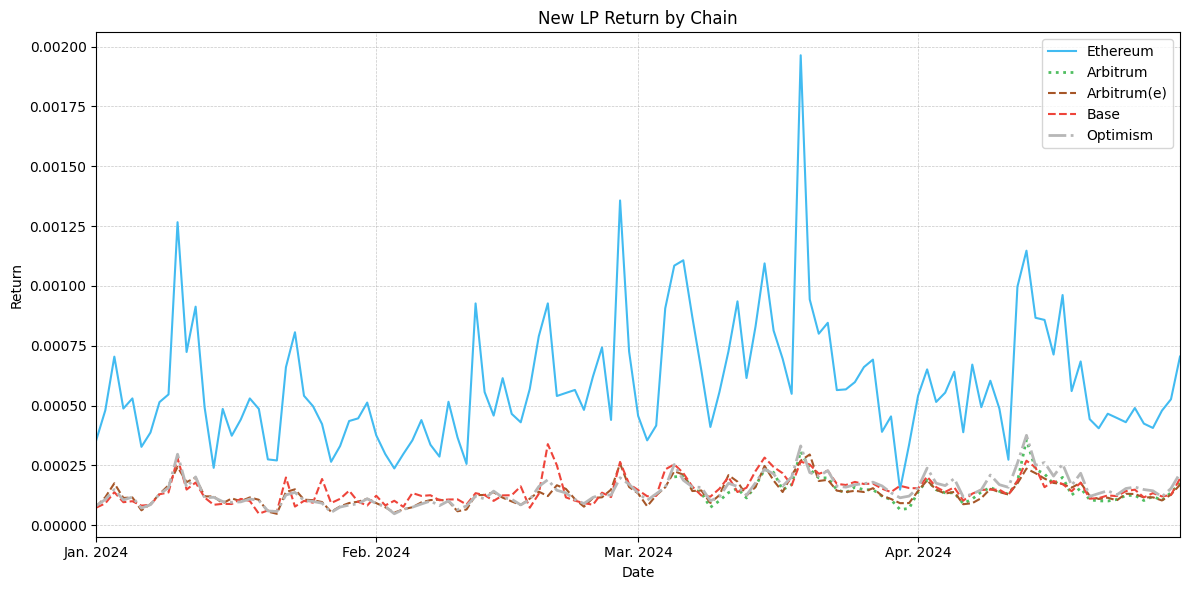

In [ ]:
# --- Line Plot: Daily TVL by Chain ---
plt.figure(figsize=(12, 6))  # Adjust figure size for academic formatting
for chain in chains:
    df = daily_results_dict[chain]
    if (chain.lower() != 'zksync'):
        if chain.lower() in plot_settings:
            settings = plot_settings[chain.lower()]
            
            # Sort by date and plot
            df = df.sort('date')
            plt.plot(
                df['date'], df['new_return'],
                color=settings['color'],
                linestyle=settings['style'],#'-',  # Use a solid line for better readability in print
                linewidth=settings['width'],#1.5,  # Slightly thinner lines for a clean look
                label=settings['label']
            )

# Customize the plot
plt.title('New LP Return by Chain')  # Academic-style title
plt.xlabel('Date')
plt.ylabel('Return')

plt.gca().xaxis.set_major_formatter(DateFormatter('%b. %Y'))  # Format x-axis as "Month. Year"
plt.gca().xaxis.set_major_locator(MonthLocator(interval=1))  # 1-month intervals

# Customize the plot
plt.xticks(rotation=0, fontsize=10)  # Rotate x-axis labels for readability
plt.yticks(fontsize=10)
#plt.legend(fontsize=10, frameon=False)  # Simplified legend
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)  # Light grid for better visibility
plt.xlim(min_date,max_date)

# Tight layout for better spacing
plt.tight_layout()

# Save the figure for academic use
plt.savefig('./LP_plots/new_return.png', dpi=300, bbox_inches='tight')  # High-resolution output

# Show the plot
plt.show()



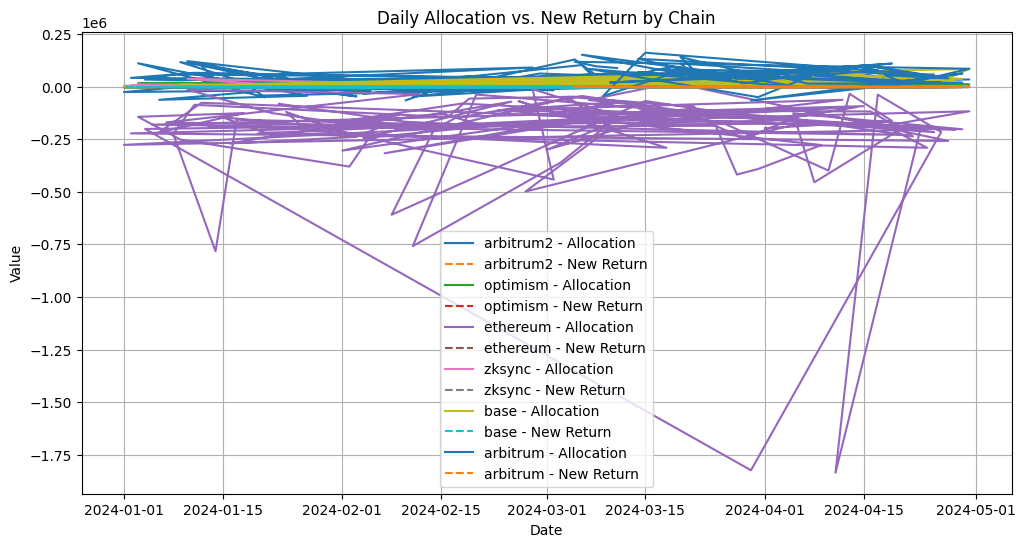

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- Line Plot: Daily Allocation vs. New Return by Chain ---
plt.figure(figsize=(12, 6))
for chain, df in daily_results_dict.items():
    plt.plot(df['date'], df['allocation'], label=f'{chain} - Allocation')
    plt.plot(df['date'], df['new_return'], linestyle='--', label=f'{chain} - New Return')
plt.title('Daily Allocation vs. New Return by Chain')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:

# --- Heatmap: New Return per Chain and Day ---
heatmap_data = np.array([
    np.pad(df['new_return'].to_numpy(), (0, max_length - len(df)), constant_values=np.nan)
    for df in daily_results_dict.values()
])
plt.figure(figsize=(12, 6))
im = plt.imshow(heatmap_data, aspect='auto', cmap='coolwarm', interpolation='none')
plt.title('Heatmap of New Return per Chain and Day')
plt.xlabel('Days')
plt.yticks(np.arange(len(daily_results_dict)) + 0.5, daily_results_dict.keys())
plt.colorbar(im, orientation='vertical')
plt.show()



NameError: name 'max_length' is not defined

In [ ]:
# --- Bar Chart: Comparison of Average New Return per Chain ---
avg_returns = [df['new_return'].mean() for df in daily_results_dict.values()]
plt.figure(figsize=(12, 6))
plt.bar(daily_results_dict.keys(), avg_returns, color=['blue', 'orange', 'green', 'purple', 'red'])
plt.title('Comparison of Average New Return per Chain')
plt.xlabel('Chain')
plt.ylabel('Average New Return')
plt.grid(True, axis='y')
plt.show()